In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from pathlib import Path
import pickle
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch 



import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Circle, Rectangle
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from pathlib import Path
import pickle
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm
from astropy.visualization import AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import SqrtStretch 
#TJ define functions needed to generate files
os.chdir('/d/ret1/Taylor/jupyter_notebooks/Research') #TJ change working directory to be the parent directory
from Py_files.Basic_analysis import *


def extract_filter_name(filename):
    '''extract entire filter name, for example: F164N
    -------------
    
    Parameters
    -------------
    file_name : type = str - name of filter's fits file of format similar to ngc5194_nircam_1v3_f164n_i2d.fits
        *note*: function keys on the "_" and .fits to get filter name, requires lower case filter names, see generalized "sort_filters" function
    
    Returns
    -------------
    filter name as string
    '''   
    # For .fits files: ngc5194_nircam_1v3_f164n_i2d.fits → "f164n"
    if filename.endswith('.fits'):
        parts = os.path.basename(filename).split('_')
        for part in parts:
            if part.startswith('f') and part[1:].replace('n', '').replace('w', '').replace('m', '').isdigit():
                return part.lower()
    # For .dat files: F070M.dat → "f070m"
    elif filename.endswith('.dat'):
        return os.path.splitext(os.path.basename(filename))[0].lower()
    return None

def get_filter_number(filter_name):
    '''extracts numbers from filter name (drops F, N, W, etc from the ends)
    -------------
    
    Parameters
    -------------
    filter_files : type = list - list of filter names
    
    Returns
    -------------
    filter name as string
    '''   
    match = re.search(r'[A-Za-z](\d+)[A-Za-z]', filter_name)  # Numbers between ANY letters
    return int(match.group(1)) if match else 0

def generate_list_of_files():
    '''cross-matches files in filter_directory to filters with images in image_directory, sorts by filter number
    -------------
    
    Parameters
    -------------
    none 
    
    Returns
    -------------
    list of arrays, first entry is the image file array, second is the filter file array, both sorted by filter numer (in name)
    '''   
    filter_directory = '/d/crow1/tools/cigale/database_builder/filters/jwst/'
    path = ['nircam', 'miri']
    filter_files = np.concatenate([glob.glob(os.path.join(filter_directory + file_path, "*.dat")) for file_path in path])
    image_directory = 'Data_files/Image_files'
    image_files = glob.glob(os.path.join(image_directory, "*.fits"))
    # Initialize aligned lists
    image_file_array = []
    filter_file_array = []
    
    # Loop through .fits files and find matching .dat files
    for fits_file in image_files:
        fits_filter = extract_filter_name(fits_file)
        if not fits_filter:
            continue  # Skip if no filter name found
        
        # Search for matching .dat file
        for dat_file in filter_files:
            dat_filter = extract_filter_name(dat_file)
            if dat_filter == fits_filter:
                image_file_array.append(fits_file)
                filter_file_array.append(dat_file)
                break  # Stop searching after first match
    filter_name_array = [f.split("/")[-1] for f in filter_file_array] #TJ generate array of just the filter names
    filter_numbers = np.array([get_filter_number(file) for file in filter_name_array]) #TJ generate array of just filter numbers
    sort_indices = np.argsort(filter_numbers) #TJ sort by these numbers
    sorted_filter_names = np.array(filter_file_array)[sort_indices]
    sorted_image_files = np.array(image_file_array)[sort_indices]
    return sorted_image_files, sorted_filter_names
#TJ define data paths and location info

karin_SDuval_IFU_files = ['Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/SW_IFU_ch4-shortmediumlong_s3d.fits'
            ]

karin_IFU_files = [ 'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/raw_IFUs/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/Arm2_Level3_ch4-shortmediumlong_s3d.fits',
            ]
Thomas_IFU_file = 'Data_files/IFU_files/M51_SW_f290lp_g395m-f290lp_s3d.fits'

SDuval_IFU_files = ['Data_files/IFU_files/raw_IFUs/SW_IFU_ch1-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch2-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch3-shortmediumlong_s3d.fits',
                  'Data_files/IFU_files/raw_IFUs/SW_IFU_ch4-shortmediumlong_s3d.fits']

Grant_conv_IFU_files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d_conv17p1um.fits']
pivot_files = []
for i in range(1,8):
    pivot_files.append(f'Data_files/IFU_files/convolved_to_2100_part{i}.fits')
jw_files = glob.glob('Data_files/IFU_files/my_convolutions/*/jw*')
sw_files = glob.glob('Data_files/IFU_files/my_convolutions/*/SW*')
my_convolutions = np.concatenate([jw_files, sw_files])
image_files, filter_files = generate_list_of_files()
filter_names = ['F115W', 'F140M', 'F150W', 'F164N', 'F182M', 'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F300M', 'F335M', 'F360M', 'F405N', 
           'F430M', 'F444W', 'F560W', 'F770W', 'F1000W', 'F1130W', 'F1280W', 'F1500W', 'F1800W', 'F2100W'] 
loc = [202.4340450, 47.1732517]
test_loc = [202.43357, 47.17296]

radius = 0.75*u.arcsec
with open('Data_files/misc_data/flux_v_radius/maximum_radii.dic', 'rb') as f:
    radius_dict = pickle.load(f)

def get_filter_wl_range(filter):
    '''Use the filter files to determine what wavelength range we need for each filter
    -------------
    
    Parameters
    -------------
    filter : type = str - string describing the filter name (case sensitive), for example "F335M"

    Returns
    -------------
    Path to newly convolved file as a string
    '''   
    _, filter_files = generate_list_of_files()
    filter_file = [filer_filepath for filer_filepath in filter_files if extract_filter_name(filer_filepath).upper() == filter][0]
    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    return filter_wl[0]*u.m, filter_wl[-1]*u.m

def plot_integrated_aperture_overlay(IFU_file, image_file, loc, radius, zoom_scale=5):
    """Display wavelength-integrated IFU data alongside 2D image."""
    from astropy.nddata import block_reduce
    
    def load_data(file):
        with fits.open(file) as hdul:
            for ext in [1, 'SCI', 0]:
                try:
                    data = hdul[ext].data
                    header = hdul[ext].header
                    if data is not None:
                        # Get 2D celestial WCS
                        wcs = WCS(header, naxis=2)
                        if data.ndim == 3:
                            # Sum over wavelength axis (axis=0)
                            integrated_data = np.nansum(data, axis=0)
                            return integrated_data, header, wcs
                        return data, header, wcs
                except (KeyError, IndexError):
                    continue
        raise ValueError(f"No valid data found in {file}")

    # Load and integrate IFU data
    ifu_integrated, ifu_header, ifu_wcs = load_data(IFU_file)
    image_data, image_header, image_wcs = load_data(image_file)
    # Convert location to pixels
    loc_sky = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg, frame='icrs')
    x_ifu, y_ifu = ifu_wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)
    x_img, y_img = image_wcs.all_world2pix(loc_sky.ra, loc_sky.dec, 0)

    # Create figure
    fig = plt.figure(figsize=(15, 7))
    
    # Plot integrated IFU data
    ax1 = fig.add_subplot(121, projection=ifu_wcs)
    im1 = ax1.imshow(ifu_integrated, origin='lower', cmap='viridis',
                    norm=ImageNormalize(ifu_integrated, stretch=AsinhStretch(0.1)))
    fig.colorbar(im1, ax=ax1, label='Integrated Flux')
    ax1.set_title('IFU Data (λ-integrated)')

    # Plot Image
    ax2 = fig.add_subplot(122, projection=image_wcs)
    im2 = ax2.imshow(image_data, origin='lower', cmap='viridis',
                    norm=ImageNormalize(image_data/8, stretch=SqrtStretch()))
    fig.colorbar(im2, ax=ax2, label='Flux')
    ax2.set_title('Image Data')

    # Add apertures and set zoom
    for ax, (x, y), wcs in zip([ax1, ax2], [(x_ifu, y_ifu), (x_img, y_img)], [ifu_wcs, image_wcs]):
        pixel_scale = np.abs(wcs.wcs.cdelt[0]) * 3600  # arcsec/pixel
        radius_pix = radius.to(u.arcsec).value / pixel_scale
        ax.add_patch(Circle((x, y), radius_pix, ec='red', fc='none', lw=2, ls='--'))
        
        # Set zoom (5x aperture radius by default)
        zoom_width = zoom_scale * radius_pix
        ax.set_xlim(x - zoom_width, x + zoom_width)
        ax.set_ylim(y - zoom_width, y + zoom_width)
    
    plt.suptitle(f"Aperture Radius: {radius}", y=0.95)
    plt.tight_layout()
    plt.show()

def get_convolved_filter_name(file):
    '''Extracts "F115W" from 'Data_files/IFU_files/f100lp_s3dIFU_convolved_tof115w.fits'
    -------------
    
    Parameters
    -------------
    file : type = str - string of a convolved IFU

    Returns
    -------------
    filter_name : type = str - string with capital letters representing the filter name
    '''   
    return file.split("convolved_to")[1].split(".f")[0].upper()

def full_coverage(filter_name, IFU_file):
    '''Checks if the IFU has full filter converage or not'''
    filter_coverage = get_filter_wl_range(filter_name)
    cube = SpectralCube.read(IFU_file, hdu = 'SCI')
    cube_range = [cube.spectral_axis[0], cube.spectral_axis[-1]]
    if filter_coverage[0] < cube_range[0]:
        return 'missing shorter'
    if filter_coverage[1] > cube_range[1]:
        return'missing longer'
    else:
        return 'good'

def get_aperture_flux(file, loc, radius, show_plot= False, zoom = None):
    '''display image of fits file, with aperture with radius at location, can also specify zoom
    -------------
    Parameters
    -------------
    file : type = str - string to fits file you want to display, can be a list of locations (len(loc) must equal len(radius))
    loc : type = either [ra, dec] in degrees, or a SkyCoord object - location of center of the aperture
    radius : type = angular unit - radius of aperture with units attached
    show_plot (optional, defaults to false) : type = Boolean - show png of image?
    zoom : type = angular unit, or list of units - width and height of the fov in the image if single value, if list [width, height]

    Returns
    -------------
    flux : type = float - in units of the image file, total flux through aperture.
    '''   

    hdul = fits.open(file)
    data = hdul[0].data
    header = hdul[0].header
    pix_area = header["PIXAR_SR"]
    # Create WCS object
    wcs = WCS(header)

    # Plot with imshow_norm
    if show_plot:
        try:
            plt.figure(figsize = (8,8*zoom[1]/zoom[0]))
        except:
            plt.figure(figsize=(8,8))
        ax = plt.subplot(projection=wcs)
        norm = simple_norm(data, stretch='asinh', percent=96.9)
        im = ax.imshow(data, norm=norm, cmap='gray', origin='lower')
        
        # Add RA/Dec gridlines and labels
        ax.coords.grid(True, color='white', ls='dotted')
        ax.coords[0].set_axislabel('RA')
        ax.coords[1].set_axislabel('Dec')
    if (type(loc[0]) == float) or (type(loc[0])==np.float64):
        x,y = wcs.all_world2pix(loc[0], loc[1], 0)
        aperture = CircularAperture((x, y), r=radius.to_value(u.deg) / header['CDELT2'])
        phot_result = aperture_photometry(data, aperture)
        flux = phot_result['aperture_sum'][0]
        if show_plot:
            aperture.plot(color='red', lw=2, alpha=0.7, label=f'{flux} MJy')
    else:
        flux = []
        for location in loc:
            x,y = wcs.all_world2pix(location[0], location[1], 0)
            aperture = CircularAperture((x, y), r=radius.to_value(u.deg) / header['CDELT2'])
            phot_result = aperture_photometry(data, aperture)
            this_flux = phot_result['aperture_sum'][0]*pix_area
            flux.append(this_flux)
            if show_plot:
                aperture.plot(color='red', lw=2, alpha=0.7, label=f'{radius}" Aperture')
    if show_plot and (zoom is not None):
        # Calculate half-width in pixels
        pix_scale = abs(header['CDELT2']) * u.deg  # pixel scale in deg/pix
        try:
            npix_half_x = (zoom[0].to(u.deg) / pix_scale).value / 2
            npix_half_y = (zoom[1].to(u.deg) / pix_scale).value / 2
            ax.set_xlim(x - npix_half_x, x + npix_half_x)
            ax.set_ylim(y - npix_half_y, y + npix_half_y)
        except:
            npix_half = (zoom.to(u.deg) / pix_scale).value / 2
            ax.set_xlim(x - npix_half, x + npix_half)
            ax.set_ylim(y - npix_half, y + npix_half)
    if show_plot:
        ax.legend()

        # Colorbar
        plt.colorbar(im, ax=ax, orientation='vertical', label='Flux')
        
        plt.title(f"{file.split('.fi')[0].split('/')[-1].split('/')[-1]}")
        plt.show()
    return flux

def get_Fnu_transmission(Fnu_array, wl_array, transmission_array, trans_wl_array):
    '''get expected flux through filter in units of whatever the flux_array is. Make sure to convert to mks units
    -------------
    
    Parameters
    -------------
    Fnu_array : type = array - array of flux density values
    wl_array : type = array - array of wavelength values for the corresponding Fnu_array values (should be in meters)
    transmission_array : type = array - array of unitless transmission coefficient
    trans_wl_array : type = array - array of wavelength values for the corresponding transmission values (should be in meters)

    
    Returns
    -------------
    total_flux : type = float - in units of flux_array
    '''   
    if ((trans_wl_array[0] < wl_array[0]) or (trans_wl_array[-1] > wl_array[-1])): #TJ Check if wavelengths are compatible with filter
        print(f'filter goes from {trans_wl_array[0]} to {trans_wl_array[-1]}, but provided Fnu array goes from {wl_array[0]} to {wl_array[-1]}')
        idx_start = np.searchsorted(trans_wl_array, wl_array[0], side='left')
        idx_end = np.searchsorted(trans_wl_array, wl_array[-1], side='right')
        
        # Expand by one index if possible
        idx_start = max(0, idx_start - 1)  # Include one lower index
        idx_end = min(len(trans_wl_array), idx_end + 1)  # Include one higher index
        
        # Slice transmission data
        trans_wl_array = trans_wl_array[idx_start:idx_end]
        transmission_array = transmission_array[idx_start:idx_end]
    if len(trans_wl_array) == 0:
        raise ValueError("No overlap between flux wavelengths and filter transmission curve")
    #TJ convert all arrays to numpy arrays for better indexing
    Fnu_array = np.array(Fnu_array)
    wl_array = np.array(wl_array)
    transmission_array = np.array(transmission_array)
    trans_wl_array = np.array(trans_wl_array)

    
    #TJ Convert wavelength to frequency, reverse so freq increases left to right
    spec_freq_array = c / wl_array[::-1]
    Fnu_array = Fnu_array[::-1]
    trans_freq_array = c / trans_wl_array[::-1]
    transmission_array = transmission_array[::-1]

    #TJ Interpolate Fnu onto the transmission frequency grid
    #TJ this is because jwst transmission arrays are averages over BW widths which are much coarser than Fnu is.
    
    interp_Fnu = np.interp(trans_freq_array, spec_freq_array, Fnu_array)
    
    
    weight = transmission_array / trans_freq_array #TJ weight the numerator and denominator by T *d_nu over nu for integration
    numerator = np.trapz(interp_Fnu * weight, trans_freq_array)#TJ perform integration
    denominator = np.trapz(weight, trans_freq_array)
    ab_mean_flux = numerator / denominator
    # Numerator: Fν * Transmission / nu integrated over frequency
    
    return ab_mean_flux.value

def which_fits(filter_file, list_of_fits):
    '''open the filter file, determine the range of wavelengths needed to compute synthetic flux through it, return which fits files
    are needed for this particular filter. This is to save time not convolving cubes we dont need.
    -------------
    
    Parameters
    -------------
    filter_file : type = str - string to location of filter file that we are interested in.
    list_of_fits : type = list - list of strings to the IFU fits files that you want to check
    
    Returns
    -------------
    needed_fits : type = list - list of strings to the fits files that are actually needed
    '''   
    filter_data = []
    with open(filter_file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                filter_data.append(data_line)
            
    header, filter_T = filter_data[:2], np.array(filter_data[2:])

    wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
    T = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
    
    min_wl, max_wl = min(wl), max(wl)
    needed_fits = []
    entirely_in = []
    for file in list_of_fits:
        cube = SpectralCube.read(file, hdu='SCI')
        wavelength = cube.spectral_axis
        if (wavelength[0].value*1e-6 < max_wl) and (wavelength[-1].value*1e-6 > min_wl):
            needed_fits.append(file)
            if ((wavelength[0].value*1e-6 < min_wl) and (wavelength[-1].value*1e-6 > max_wl)):
                entirely_in.append(True)
            else:
                entirely_in.append(False)
    needed_fits = np.array(needed_fits)

    if (sum(entirely_in) == 1):
        return needed_fits[entirely_in]
    elif ((len(needed_fits) > 1) & (sum(entirely_in) == 0)):
        print(f'More than one IFU file is needed for filter {extract_filter_name(filter_file)}')
        return needed_fits
    elif ((len(needed_fits) > 1) & (sum(entirely_in) > 1)):
        print(f'More than one IFU file could be used for filter {extract_filter_name(filter_file)}')
        return needed_fits[0]

def try_radii(IFU_file, filter_name, loc, show_plot = False, labeler = None, use_default = False):
    image_candidates = [img for img in image_files if extract_filter_name(img).upper() == filter_name]
    if not image_candidates:
        print(f"No matching image for filter {filter_name}")
    image_file = image_candidates[0]

    def radius_to_size(r, radii):
        min_radius = np.min(radii)
        max_radius = np.max(radii)
        # Linearly map radius to marker size between 30 and 110
        return 30 + (r - min_radius) / (max_radius - min_radius) * (110 - 30)

    filter_files_maybe = [filt for filt in filter_files if extract_filter_name(filt).upper() == filter_name]
    if not image_candidates:
        print(f"No matching image for filter {filter_name}")
    filter_file = filter_files_maybe[0]


    filter_data = []
    with open(filter_file, 'r') as f:
        header = f.readline().strip().split()
        for line in f:
            data_line = line.strip().split()
            filter_data.append(data_line)
    if len(filter_data) < 2:
        print(f"Filter file {filter_file} seems empty or malformed.")

    header, filter_T = filter_data[:2], np.array(filter_data[2:])
    filter_wl = np.array([try_float(row[0]) * 1e-10 for row in filter_T])
    filter_trans = np.array([try_float(row[1]) for row in filter_T])
    relative_fluxes = []
    if use_default:
        max_radius = radius_dict[extract_filter_name(filter_file).upper()]
    else:
        max_radii = []
        for IFU_file_temp in IFU_file:
            max_radii.append(find_max_radius(IFU_file_temp, image_file, loc, min_radius=0.1*u.arcsec, max_radius=10.0*u.arcsec, tolerance=0.01*u.arcsec)[0])
        max_radius = min(max_radii)
    radii = np.linspace(0.1, max_radius.value, 10)
    print(f'Using 10 radii between 0.1 and {max_radius}')
    for radius in radii:
        radius = radius*u.arcsec
        photo_flux = get_image_flux(image_file, loc, radius, replace_negatives=0)

        marker_size = radius_to_size(radius.value, radii)
        spectrum = stitch_spectra(IFU_file, loc, radius, replace_negatives = 0)
        flux = get_Fnu_transmission(spectrum['intensity'], spectrum['wavelength'], filter_trans, filter_wl)/photo_flux
        relative_fluxes.append(flux)
        if show_plot:
            if not labeler:
                scatter_point = 'o'
            else:
                scatter_point = labeler
            plt.scatter(radius.value, flux, s = marker_size, marker = scatter_point)
    return relative_fluxes, radii

def is_aperture_fully_covered(IFU_file, image_file, loc, radius):
    '''
    Check if a circular aperture is fully within imaged regions for both IFU and image files.
    
    Parameters:
    -----------
    IFU_file : str
        Path to the IFU FITS file (must have WCS and SCI extension).
    image_file : str
        Path to the image FITS file (must have WCS and valid data).
    loc : tuple (ra, dec)
        Sky coordinates of the aperture center in degrees.
    radius : float
        Aperture radius in arcseconds.
        
    Returns:
    --------
    tuple (bool, bool)
        (IFU_fully_covered, image_fully_covered)
        True if aperture is fully within imaged regions for each file.
    '''
    def _check_coverage(file, ext):
        # Open file and get data + WCS
        with fits.open(file) as hdul:
            data = hdul[ext].data
            header = hdul[ext].header
            wcs = WCS(header)
            
            # Handle 3D IFU cubes (use first wavelength slice)
            if data.ndim == 3:
                data = data[0]
            
            # Create coverage mask (1=imaged, 0=NaN/unimaged)
            coverage_mask = np.where(np.isnan(data) | (data == 0), 0, 1)
            
            # Convert sky coordinates to pixel coordinates
            loc_sky = SkyCoord(ra=loc[0] * u.deg, dec=loc[1] * u.deg, frame='icrs')
            x_center, y_center = wcs.celestial.all_world2pix(loc_sky.ra.deg, loc_sky.dec.deg, 0)
            
            # Calculate pixel scale (arcsec/pixel)
            try:
                pixel_scale = np.abs(header['CDELT1']) * 3600  # deg -> arcsec
            except KeyError:
                pixel_scale = np.sqrt(header['PIXAR_A2'])  # Fallback for JWST files
            
            radius_pix = radius.value / pixel_scale
            # Measure coverage
            aperture = CircularAperture((x_center, y_center), r=radius_pix)
            phot_table = aperture_photometry(coverage_mask, aperture)
            measured_area = phot_table['aperture_sum'][0]
            expected_area = np.pi * (radius_pix ** 2)
            
            # Allow 1-pixel tolerance for edge effects
            return np.isclose(measured_area, expected_area, atol=1.0)

    # Check IFU file (SCI extension)
    ifu_covered = _check_coverage(IFU_file, ext='SCI')
    
    # Check image file (primary HDU or SCI)
    try:
        image_covered = _check_coverage(image_file, ext=0)  # Try primary HDU
    except (KeyError, AttributeError):
        image_covered = _check_coverage(image_file, ext='SCI')  # Fallback to SCI
    
    return (ifu_covered, image_covered)


def find_max_radius(IFU_file, image_file, loc, min_radius=0.1*u.arcsec, max_radius=10.0*u.arcsec, tolerance=0.01*u.arcsec):
    """
    Find the maximum aperture radius (arcsec) fully covered in both IFU and image files.
    Uses binary search between min_radius and max_radius.
    
    Parameters:
    -----------
    IFU_file : str
        Path to IFU FITS file.
    image_file : str
        Path to image FITS file.
    loc : tuple (ra, dec)
        Sky coordinates in degrees.
    min_radius : float
        Minimum aperture radius to test (arcsec).
    max_radius : float
        Maximum aperture radius to test (arcsec).
    tolerance : float
        Precision threshold for convergence (arcsec).
        
    Returns:
    --------
    float
        Maximum fully covered radius (arcsec), or 0 if no valid radius found.
    """
    def _is_covered(radius):
        ifu_ok, image_ok = is_aperture_fully_covered(IFU_file, image_file, loc, radius)
        return ifu_ok and image_ok
    
    # Binary search
    best_radius = 0.0
    while max_radius - min_radius > tolerance:
        mid_radius = (min_radius + max_radius) / 2
        if _is_covered(mid_radius):
            best_radius = mid_radius
            min_radius = mid_radius  # Try larger radii
        else:
            max_radius = mid_radius  # Try smaller radii
    IFU_pix_scale = (fits.open(IFU_file)['SCI'].header['CDELT2']*u.deg).to(u.arcsec)
    image_pix_scale = (fits.open(image_files[0])['SCI'].header['CDELT2']*u.deg).to(u.arcsec)
    return (best_radius if best_radius > 0 else 0.0), best_radius/IFU_pix_scale,  best_radius/image_pix_scale

def load_and_sort_convolved_Karin_spectrum(file_path):
    '''import data and sort by wavelength from very particularly structured file
    -------------
    
    Parameters
    -------------
    file_path : type = str - path to file with data
    
    Returns
    -------------
    structured array ('wavelength', 'intensity', 'uncertainty') where intensity and uncertainty are in W/m2/Hz
    '''    
    with open(file_path, 'r') as file:
        header = file.readline().strip().split()
        #TJ check first line structure for compliance
        if ((len(header) == 3) & (type(try_float(header[0])) == type(0.1)) & (type(try_float(header[1])) == type(0.1)) & (type(try_float(header[2])) == type(0.1))):
            data_list = []
            data_list.append((try_float(header[0])*1e-6, try_float(header[1])*1e-20, try_float(header[2])*1e-20))
            aperture_area_sr = (np.pi * (((0.75*u.arcsec).to(u.rad))**2)).value
            for line in file:
                parts = line.strip().split(maxsplit=3)
                
                #TJ Convert numeric columns to floats
                wavelength = float(parts[0])*1e-6 #TJ float required for sorting
                intensity = try_float(parts[1])*1e-20 * aperture_area_sr
                uncertainty = try_float(parts[2])*1e-20 * aperture_area_sr
                
                data_list.append((wavelength, intensity, uncertainty))
        
            #TJ Define dtype with notes as string
            dtype = [
                ('wavelength', float),
                ('intensity', float),
                ('uncertainty', float),
            ]
            
            data = np.array(data_list, dtype=dtype)
            sorted_data = np.sort(data, order=['wavelength'])  #TJ Sort by wavelength
            
            return sorted_data
        else:
            print('''File format is not as expected. Should be 3 columns no header, if not, see "import_data_and_sort_by_wavelength"
            function from Flux_calibration notebook''')
            return None

def get_image_flux(image_file, loc, radius, replace_negatives = False):
    '''extract flux from image file with aperature of radius, centered at ra,dec = loc
    -------------
    
    Parameters
    -------------
    image_file : type = str - string to location of image fits file
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = float - radius of aperture, must have units attached (like u.deg or u.arcsecond)
    
    Returns
    -------------
    flux_density observed through filter
    '''
    #TJ assign location as SkyCoord object
    if type(loc) == list:
        spatial_coords = SkyCoord(ra=loc[0]*u.deg, dec=loc[1]*u.deg)
    elif type(loc) == SkyCoord:
        spatial_coords = loc
    else:
        print('loc is not a list of ra, dec and it is not a SkyCoord object.')
        return None
    hdul = fits.open(image_file) #TJ load file
    
    data = hdul['SCI'].data*1e-20  #TJ convert flux density to mks units
    if replace_negatives is not False:
        min_positive = min(data[data>0])
        data[data<0] = replace_negatives*min_positive
    header = hdul['SCI'].header #TJ load header
    if header['BUNIT'] != 'MJy/sr': #TJ check if units are MJy/sr, output will be nonsensical if not
        print('flux is NOT in MJy/sr. review get_image_flux function to fix')
        return None
    pix_area = header["PIXAR_SR"] #TJ define the angular size of a pixel in staradians
    wcs = WCS(header) #TJ read in the world coordinate system
    radius_pixels = (radius).to_value(u.deg) / abs(header['CDELT2']) #TJ get the radius of the aperture in number of pixels
    
    #TJ Convert RA/Dec to pixel coordinates
    x, y = wcs.all_world2pix(spatial_coords.ra.deg, spatial_coords.dec.deg, 0)
    aperture = CircularAperture((x, y), r = radius_pixels)
    
    #TJ Perform aperture photometry
    phot_result = aperture_photometry(data, aperture)
    total_flux = phot_result['aperture_sum'][0]*pix_area  #TJ the result is in pixel units, multiply by steradians per pixel to get units right

    return total_flux    


def stitch_spectra(fits_files, loc, radius, anchor_idx=0, replace_negatives = False):
    """
    Corrected stitching function that properly handles non-zero anchors
    """
    # 1. Load anchor spectrum
    anchor = get_IFU_spectrum(fits_files[anchor_idx], loc, radius, replace_negatives=replace_negatives)
    
    # 2. Initialize combined spectrum with anchor
    combined = {
        'wavelength': anchor['wavelength'].copy(),
        'intensity': anchor['intensity'].copy()
    }
    
    # 3. Stitch left side (lower wavelengths)
    for i in reversed(range(anchor_idx)):  # Files before anchor
        print(f'\nStitching LEFT: file {i} to anchor')
        current = get_IFU_spectrum(fits_files[i], loc, radius, replace_negatives = replace_negatives)
        
        # Left stitching should prepend the new segment
        combined = stitch_two_spectra(current, combined, direction='left')
    
    # 4. Stitch right side (higher wavelengths)
    for i in range(anchor_idx+1, len(fits_files)):
        print(f'\nStitching RIGHT: file {i} to combined')
        current = get_IFU_spectrum(fits_files[i], loc, radius)
        
        combined = stitch_two_spectra(combined, current, direction='right')
    print(f'Newly combined spectrum goes from {combined["wavelength"][0]} to {combined["wavelength"][-1]}')
    return combined

def stitch_two_spectra(spec1, spec2, direction):
    """Properly concatenates spectra in both directions"""
    # Find overlap
    if direction == 'right':
        overlap_min = max(spec1['wavelength'][0], spec2['wavelength'][0])
        overlap_max = min(spec1['wavelength'][-1], spec2['wavelength'][-1])
        # Right stitching: spec1 = combined, spec2 = new right segment
        keep_from_spec2 = spec2['wavelength'] > spec1['wavelength'][-1]
    else:  # left
        overlap_min = max(spec1['wavelength'][0], spec2['wavelength'][0])
        overlap_max = min(spec1['wavelength'][-1], spec2['wavelength'][-1])
        # Left stitching: spec1 = new left segment, spec2 = combined
        keep_from_spec2 = spec2['wavelength'] > spec1['wavelength'][-1]  # Keep anchor's right side
    
    # Calculate offset
    mask1 = (spec1['wavelength'] >= overlap_min) & (spec1['wavelength'] <= overlap_max)
    mask2 = (spec2['wavelength'] >= overlap_min) & (spec2['wavelength'] <= overlap_max)
    
    interp_flux = np.interp(
        spec1['wavelength'][mask1],
        spec2['wavelength'][mask2],
        spec2['intensity'][mask2]
    )
    offset = np.nanmedian(spec1['intensity'][mask1] - interp_flux)
    print(f'Stitching these sections required the longer wavelength spectrum to be corrected by {offset}')
    print(f'This corresponds to a correction of {offset/np.nanmedian(interp_flux)}')
    # Apply correction and concatenate
    corrected = spec2['intensity'] + offset
    
    if direction == 'right':
        new_wl = np.concatenate([spec1['wavelength'], spec2['wavelength'][keep_from_spec2]])
        new_flux = np.concatenate([spec1['intensity'], corrected[keep_from_spec2]])
    else:  # left
        new_wl = np.concatenate([spec1['wavelength'], spec2['wavelength'][keep_from_spec2]])
        new_flux = np.concatenate([spec1['intensity'], corrected[keep_from_spec2]])
    
    return {'wavelength': new_wl, 'intensity': new_flux}

/tmp/ipykernel_644034/442794937.py:281: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


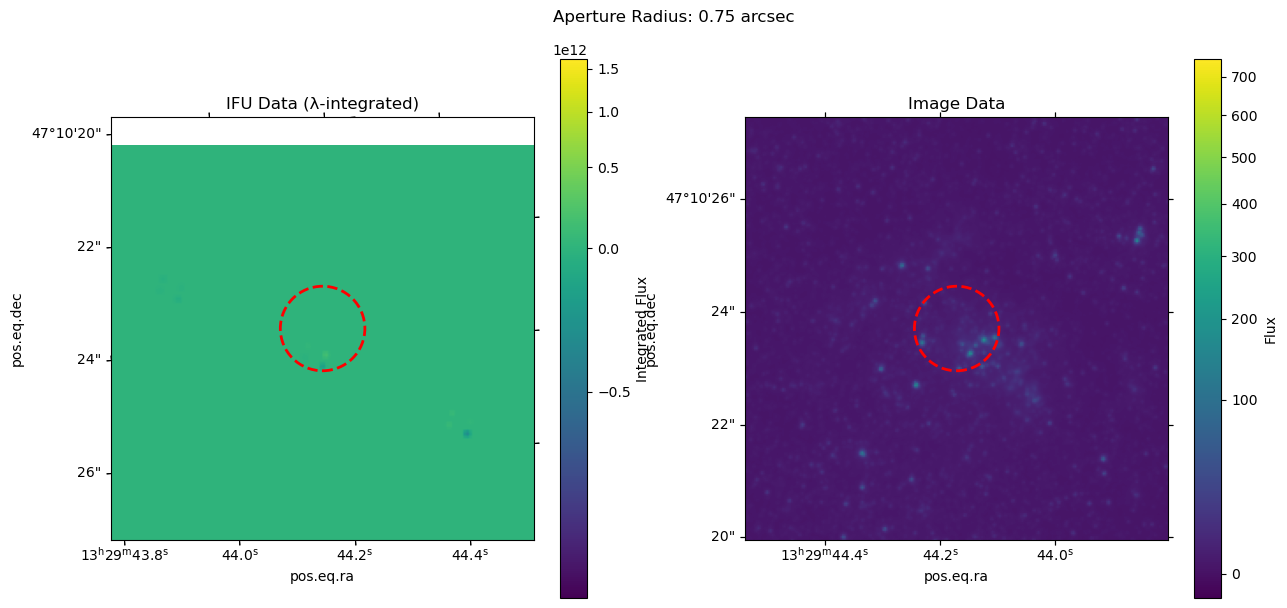